In [1]:
from datetime import date

print("Last run date:", date.today())

Last run date: 2024-08-08


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import os
from scipy.cluster.hierarchy import linkage
import matplotlib.ticker as ticker
from sklearn.decomposition import PCA

# import custom functions
import lib.figs_funcs as fig_func
import lib.funcs_ko as funcs_ko
import lib.NetAnalysis as na
import lib.funcs_general as funcs_general

import os
current_path = os.getcwd()

%load_ext autoreload
%autoreload 2

In [3]:
matplotlib.rc('text', usetex=True)
sns.set(font='Avenir')
sns.set(style="white")

# Information and Data Loading

In [4]:
path = "/Users/cleliacorridori/Dropbox_2021 Dropbox/Jorah Mormont/GRN_Inference/" # for Mac
path_data = path+"DATA/"
path_figs = path+"FIG"


In [5]:
# genes of OUR dataset
genes_reference = np.loadtxt(path_data+"general_info/genes_order.csv", dtype="str") #selected genes

# time steps
time=["00h", "06h", "12h", "24h", "48h"]

# Classifying genes based on the Carbognin paper (2023)
naive = ["Klf4", "Klf2", "Esrrb", "Tfcp2l1", "Tbx3", "Stat3", "Nanog", "Sox2"]
formative_early = ["Nr0b1", "Zic3", "Rbpj"]
formative_late = ["Utf1", "Etv4", "Tcf15", "Dnmt3a", "Dnmt3b", "Lef1", "Otx2", "Pou3f1", "Etv5"]

# Identifying genes in the dataset that are not classified into the above categories
other = [x for x in genes_reference if x not in naive and x not in formative_early and x not in formative_late]


## Neighbours interactions

In [6]:
Known_Interactions_Exp = ["Stat3 Klf4 1", "Nanog Esrrb 1", "Stat3 Dnmt3b -1", 
                "Nanog Otx2 -1", "Nanog Pou3f1 -1",
                "Stat3 Gbx2 1", "Stat3 Tfcp2l1 1", 
                "Otx2 Pou3f1 1", "Otx2 Dnmt3a 1", 
                "Tcf7l1 Esrrb -1", "Tcf7l1 Klf2 -1", "Tcf7l1 Nanog -1", "Tcf7l1 Nr0b1 -1",  "Tcf7l1 Tfcp2l1 -1",  
                "Rbpj Nanog -1", "Rbpj Tbx3 -1", "Etv5 Lef1 1", "Etv5 Pou3f1 1"]


## PST + MB scRNA-seq data Loading

In [7]:
df_lN_mb_pst = pd.read_csv(path_data + "GE_data/processed/imp_genes_LogNorm_PST_MB.csv", header=0, index_col=0, sep=",")

# check che df_lN_mb_pst.index == genes_reference
print(np.sum(df_lN_mb_pst.index == genes_reference)/len(genes_reference))
print("LogNorm dims: ", df_lN_mb_pst.shape)

1.0
LogNorm dims:  (24, 9547)


In [8]:
data_LN = df_lN_mb_pst.copy()
data_LN.columns = np.arange(0,len(data_LN.columns))
data_LN.index = np.arange(0,len(data_LN.index))

data_LN.head(3)

,0,1,2,3,4,5,6,7,8,9,...,9537,9538,9539,9540,9541,9542,9543,9544,9545,9546
0,1.237182,1.233101,1.243267,1.243267,1.258404,1.267722,1.283406,1.280832,1.280832,1.278514,...,0.219237,0.219237,0.219237,0.219237,0.219237,0.219237,0.219237,0.219237,0.228717,0.228717
1,1.143295,1.152089,1.142363,1.142363,1.148623,1.156669,1.146918,1.144345,1.160804,1.173730,...,0.603555,0.594118,0.579160,0.579160,0.567149,0.567149,0.561093,0.561093,0.547104,0.538954
2,0.279826,0.288620,0.294988,0.287320,0.273908,0.284033,0.296715,0.296715,0.296715,0.296715,...,0.227777,0.227777,0.227777,0.227777,0.227777,0.235784,0.235784,0.244157,0.250020,0.250020


### Save the Initial vector for SIMULATION


This vector is required from SCODE algorithm


In [9]:
n_cells = 1000 # s.t. it is stable (we have 2000 time points in 2iL state)

# Creating a column of integers from 0 to the length of the series
df_saving_index = pd.DataFrame(range(len(genes_reference))).set_index(genes_reference)

# concatenating the series and the index
input_ge_SCODE = pd.concat([df_saving_index, df_lN_mb_pst.iloc[:,:n_cells].mean(axis=1)], axis=1)

saving = False
if saving:
    # Saving the input_ge_SCODEing DataFrame as a tab-separated text file named 'input_ge_SCODE.txt'
    input_ge_SCODE.to_csv(path_data+"OUT_SCODE_LN/initial_GE_LogNorm_MB.txt", sep='\t', index=False, header=False)


## PST Data

In [10]:
pst_df = pd.read_csv(path_data+'input_data/cellinfo_pseudotime_3no2CLC_22_09_22.txt',
                              header = 0, sep = ' ', quotechar = '"', 
                              names = ["barcodes", "time", "pst"])

# sorting in ascending values of pseudo-time
pst_df = pst_df.sort_values(by=['pst'])

column_names = pst_df["barcodes"]

In [11]:
data_PST = pst_df.replace("00h", int(0)).replace("06h", int(6)).replace("12h", int(12)).replace("24h", int(24)).replace("48h", int(48))
data_PST = data_PST.iloc[:,1:] #remove Barcodes, keeping only time and pst

#normalize pst between 0 and 1
data_PST["pst"] = data_PST["pst"]/(data_PST["pst"].max())

In [12]:
# Fixed threshold for mini-bulk rolling average
mb_wind = 150

# rolling average on PST values as done for the mini-bulk scRNA-seq data with pst
data_PST = data_PST.rolling(window=mb_wind, axis=0).mean().dropna(axis=0)
data_PST["time"] = data_PST["time"].round().astype('int')

# rename indices
data_PST.index = np.arange(0,len(data_PST.index))
print(data_PST.shape)

data_PST.head(3) # Data formatted as required


(9547, 2)


,time,pst
0,1,0.007673
1,1,0.007849
2,1,0.008025


In [13]:
# save as csv file the data_PST
saving = False
if saving:
    data_PST.to_csv(path_data+"/PST_MB_values_scaled.txt", sep='\t', index=False, header=False)
    


## Log2FC Data

### Leeb Data

In [14]:
df_KO_N24_Leeb_uncl = pd.read_csv(path_data+'Leeb_Data_Orig/df_KO_N24_uncleaned.csv', index_col=0, header=0)
df_KO_N24_Leeb_uncl.head(2)

,Rbpj,Etv5,Tcf7l1
Klf4,2.890194,2.386695,1.300426
Klf2,0.492426,1.008604,2.338680


### Kalkan Data

In [15]:
df_tKO_Kalkan = pd.read_csv(path_data + 'Kalkan_Data/df_tripleKO_diff.csv', index_col=0, header=0)


# SCODE

## Check on RSS (100 trials)

In [16]:
# Extract column indices into an array
col_indices = np.array(data_LN.columns)

# Perform random sampling of the indices while keeping the order
sampled_indices = np.sort(np.random.choice(col_indices, size=int(len(col_indices) * 0.8), replace=False))
training_data = data_LN[sampled_indices]


In [17]:
# Train and Test
# training_data = data_LN.sample(frac=0.8, random_state=2407, replace=False, axis=1)
testing_data  = data_LN.drop(training_data.columns, axis=1)

training_time = data_PST.loc[training_data.columns, :]
testing_time  = data_PST.drop(training_data.columns, axis=0)

# print(training_data.shape[1]+testing_data.shape[1])
print(training_data.shape, testing_data.shape)
print(training_time.shape, testing_time.shape)


(24, 7637) (24, 1910)
(7637, 2) (1910, 2)


In [18]:
saving = True
base_path = path_data + "IN_SCODE/Data/"

if saving:
    training_data.to_csv(base_path + 'train_data_sort.txt', header=None, index=None, sep='\t', mode='w')
    training_time.to_csv(base_path + 'train_time_sort.txt', header=None, index=None, sep='\t', mode='w')
    
    testing_data.to_csv(base_path + 'test_data_sort.txt', header=None, index=None, sep='\t', mode='w')
    testing_time.to_csv(base_path + 'test_time_sort.txt', header=None, index=None, sep='\t', mode='w')


# Matrices computation

For each D value we compute 100 trials as suggested in the Paper

In [19]:
# path1 =  path+"1_NetworkInference/"

# Train part with more executions
genes = 24
D = [2,3,4,6,8]
cells_train = training_data.shape[1]
cells_test = testing_data.shape[1]
iters = 100
data_GE  = training_data 
data_PST = training_time 
Nexp=100

for jj in range(len(D)):
    print("D: ", D[jj])
    for ii in range(Nexp):
        print("Exp ", ii)
        out=path_data + "IN_SCODE/OUT_SCODE/PST_MB/out_z"+str(D[jj])+"/exp_"+str(ii)
        if not os.path.isdir(out):
            os.makedirs(out)
        out_file = "OUT_SCODE/PST_MB/out_z"+str(D[jj])+"/exp_"+str(ii)+"/RSS_test_prova.txt"
        # Train
        ! Rscript ~/Downloads/SCODE-master/SCODE.R /Users/cleliacorridori/Dropbox_2021\ Dropbox/Jorah\ Mormont/GRN_Inference/DATA/IN_SCODE/Data/train_data.txt /Users/cleliacorridori/Dropbox_2021\ Dropbox/Jorah\ Mormont/GRN_Inference/DATA/IN_SCODE/Data/train_time.txt {out} {genes} {D[jj]} {cells_train} {iters}
        # Test
        ! Rscript ~/Downloads/SCODE-master/RSS.R /Users/cleliacorridori/Dropbox_2021\ Dropbox/Jorah\ Mormont/GRN_Inference/DATA/IN_SCODE/Data/test_data.txt /Users/cleliacorridori/Dropbox_2021\ Dropbox/Jorah\ Mormont/GRN_Inference/DATA/IN_SCODE/Data/test_time.txt {out} {out_file} {genes} {D[jj]} {cells_test}
        


# Results Evaluation

In [20]:
# Compute D quantile
genes = 24
D = [2,4,6,8]
cells_train = 7638  # training_data.shape[1]
cells_test = 1909  # testing_data.shape[1]
iters = 100
Nexp=100

RSS_vect = np.zeros((len(D), Nexp))
RSS_quantile = np.zeros((3,len(D)))

A_sample = np.zeros((genes, genes, len(D), Nexp))
for jj in range(len(D)):
    print("D: ", D[jj])
    for ii in range(Nexp):
        out=       path_data+"OUT_SCODE_LN/PST_MB/out_z"+str(D[jj])+"/exp_"+str(ii)
        out_file = path_data+"OUT_SCODE_LN/PST_MB/out_z"+str(D[jj])+"/exp_"+str(ii)+"/RSS_test.txt"
        RSS_vect[jj,ii] = np.array(pd.read_csv(out_file, sep="\t", header=None))
        A_sample[:,:,jj,ii] = pd.read_csv(out+"/A.txt", sep="\t", header=None)

    RSS_quantile[:,jj] = np.array([np.quantile(RSS_vect[jj,:], 0.25), np.quantile(RSS_vect[jj,:], 0.5), np.quantile(RSS_vect[jj,:], 0.75)])


D:  2
D:  4
D:  6
D:  8


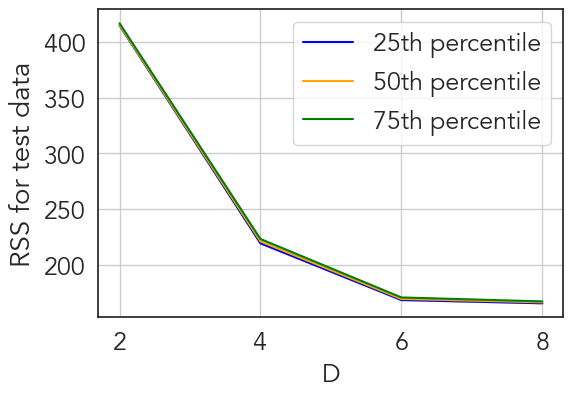

In [21]:
# Set the size of the figure
plt.figure(figsize=(6,4))
plt.rc('xtick', labelsize=18)
plt.rc('ytick', labelsize=18)
plt.rcParams['text.usetex'] = False
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Avenir'

# Plot each quantile and fill between the 25th and 75th percentiles
plt.plot(D, RSS_quantile[0, :], label="25th percentile", color='blue')
plt.plot(D, RSS_quantile[1, :], label="50th percentile", color='orange')
plt.plot(D, RSS_quantile[2, :], label="75th percentile", color='green')
plt.fill_between(D, RSS_quantile[0, :], RSS_quantile[2, :], color='gray', alpha=0.5)

# Adding legend
plt.legend(fontsize=18)
plt.ylabel("RSS for test data", fontsize=20)
plt.xlabel("D", fontsize=18)
plt.grid()

if saving:
    plt.savefig(path_figs + "/RSS_quantile_SCODE.svg", bbox_inches='tight', format='svg', transparent=True)

plt.show()


In [22]:
# for each D: reordering in ascending order of RSS and then take the 50 smallest RSS
A_sel = np.zeros((genes, genes, len(D), 50))
A_lin = np.zeros((genes*genes, len(D), 50))

for jj in range(len(D)):
    idx = np.argsort(RSS_vect[jj,:])[:50]  
    
    A_sel[:,:,jj,:] = A_sample[:,:,jj,idx]
    A_lin[:,jj,:] = A_sample[:,:,jj,idx].reshape(genes*genes, 50)
        

In [23]:
A_quantile = np.zeros((3,len(D)))
for jj in range(len(D)):
    A_exp_corr = np.corrcoef(A_lin[:,jj,:].T)
    A_quantile[:,jj] = np.quantile(A_exp_corr, [0.25, 0.5, 0.75])

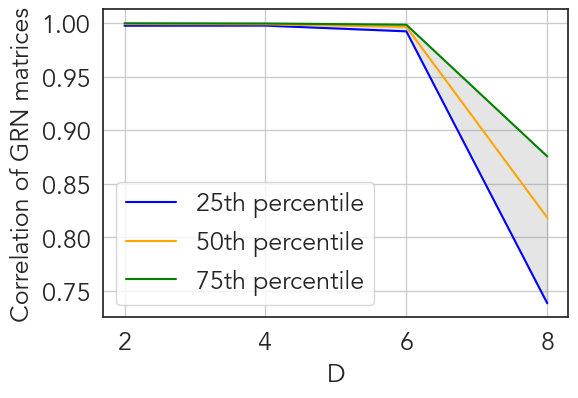

In [24]:
# Set the figure size and font size for ticks
plt.figure(figsize=(6, 4))
plt.rc('xtick', labelsize=18)
plt.rc('ytick', labelsize=18)
plt.rcParams['font.sans-serif'] = 'Avenir'
plt.rcParams['text.usetex'] = False

plt.plot(D, A_quantile[0, :], label="25th percentile", color='blue')
plt.plot(D, A_quantile[1, :], label="50th percentile", color='orange')
plt.plot(D, A_quantile[2, :], label="75th percentile", color='green')
# Add semi-transparent area between the first and last quantile (assumed to be 25th and 75th)
plt.fill_between(D, A_quantile[0, :], A_quantile[-1, :], color='gray', alpha=0.2)
plt.legend(fontsize=18,  loc='lower left')
plt.ylabel("Correlation of GRN matrices", fontsize=18)
plt.xlabel("D", fontsize=18)
plt.grid()

output_filename = f"{path_figs}/D_Correlation_SCODE.svg"
if saving:
    plt.savefig(output_filename, bbox_inches='tight', dpi=300, format='svg', transparent=True)

plt.show()


# Inferred GRN

In [25]:
DD = 2 # index of the selected D
print("D=", D[DD])

# Number of best inferred networks
N_sel_A = 50

# threshold for selecting links (interaction values)
sel_thr = 0.0

# averaging over the best 50 networks
A_tot = np.sum(A_sel[:,:,DD,:N_sel_A], axis=2 )/N_sel_A

D= 6


In [26]:
TP_fraction, TP_info = funcs_general.TP_check(Known_Interactions_Exp, 
                                            A_tot, genes_reference,
                                            inferred_int_thr=0,
                                            Norm=True)

print("TP fraction ", TP_fraction)


TP fraction  0.6666666666666666


/Users/cleliacorridori/Dropbox_2021 Dropbox/Jorah Mormont/IGNITE_code/GRN_Inference_CODE/lib/figs_funcs.py:189: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbarM.ax.set_yticklabels(cbarM.ax.get_yticklabels(), fontname='Avenir')


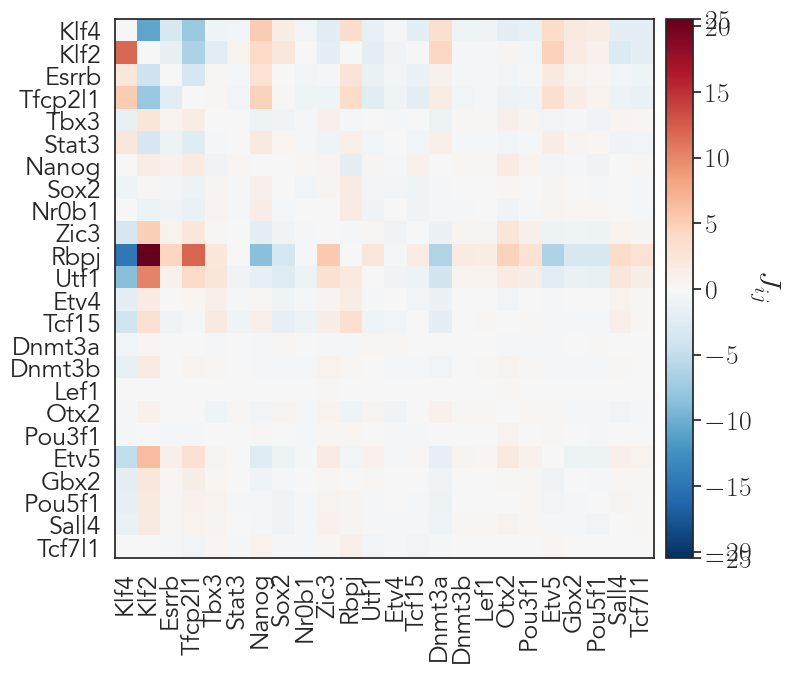

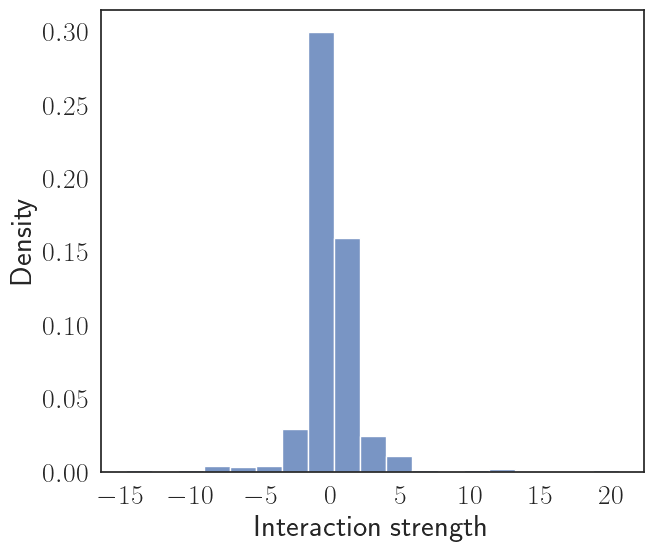

In [27]:
# Removing the diagonal, not interested in self-interactions
best_model_nodiag = A_tot.copy()
np.fill_diagonal(best_model_nodiag, 0)

fig, ax = plt.subplots(1, 1, figsize=(8,7))
fig_func.plotmat(best_model_nodiag, fig, ax, genes_reference, "", fix=False)
adjacency_matrix_path = os.path.join(path_figs, "GRN_SCODE_LN_pst_mb.svg")
plt.savefig(adjacency_matrix_path, format='svg')
plt.show()
plt.close(fig)  

plt.figure(figsize=(7,6))
bins = np.linspace(np.ndarray.flatten(best_model_nodiag).min(), 
                   np.ndarray.flatten(best_model_nodiag).max(), 20)
sns.histplot(np.ndarray.flatten(best_model_nodiag), stat="density", bins=bins)
plt.xlabel("Interaction strength", fontsize=22, fontname='Avenir')
plt.ylabel('Density', fontsize=22, fontname='Avenir')
plt.xticks(fontsize=20, fontname='Avenir')
plt.yticks(fontsize=20, fontname='Avenir')
distribution_path = os.path.join(path_figs, "GRN_SCODE_LN_pst_mb_distribution.svg")
plt.savefig(distribution_path, format='svg')
plt.show()   
plt.close()  



In [28]:
saving = False
if saving:
    np.savetxt(path_data+"OUT_SCODE_LN/A_sel_LogNorm_MB.txt",A_tot)


In [29]:
load = False
if load:
    A_tot = np.loadtxt(path_data+"OUT_SCODE_LN/A_sel_LogNorm_MB.txt")


## Network of Known Interactions

Total edges drawn: 12


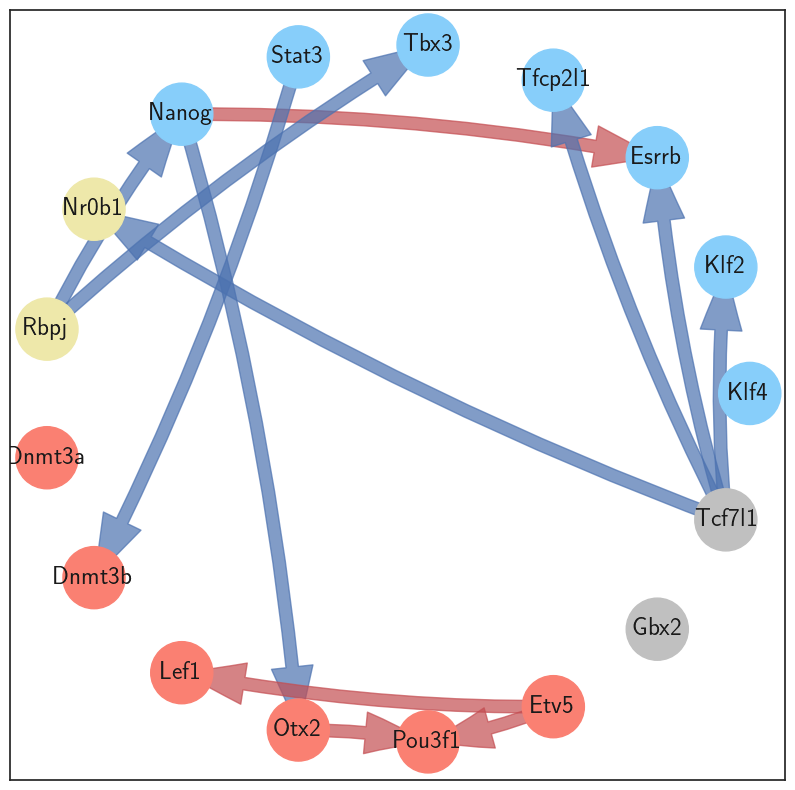

In [30]:
adj_matx = na.to_adj_matrix(A_tot, thr = 0.0)
# visualize the adjacency matrix
visualise_adj = False
if visualise_adj:
    plt.figure(figsize=(7,6))
    sns.heatmap(adj_matx, cmap="coolwarm", cbar=False, center=0, linewidth=.5)
    plt.xticks(fontsize=16, rotation=90, labels=genes_reference, ticks=np.arange(0.5, len(genes_reference), 1))
    plt.yticks(fontsize=16, rotation=0, labels=genes_reference, ticks=np.arange(0.5, len(genes_reference), 1))

visualise_network_true = False
if visualise_network_true:
    # visualize the network
    na.visualize_graphTrue(adj_matx, genes_reference, naive, formative_early, formative_late, Known_Interactions_Exp,"")
    plt.show()
    
na.visualize_graphSel(adj_matx, genes_reference, naive, formative_early, formative_late, Known_Interactions_Exp,"")
KInet_path = os.path.join(path_figs, "GRN_SCODE_LN_pst_mb_KInet.svg")
plt.savefig(KInet_path, format='svg')
plt.show()
plt.close()

# Dynamic Simulation - Data Generation

In [31]:
matplotlib.rc('text', usetex=True)
sns.set(font='Avenir')
sns.set(style="white")

In [32]:
compute = False
N_sim=500
df_sim = np.zeros((len(genes_reference), 101, N_sim))

for ii in range(N_sim):
    if ii%100==0:
        print("Exp ", ii)
    out_sim = "/Users/cleliacorridori/Dropbox_2021\ Dropbox/Jorah\ Mormont/GRN_Inference/DATA/OUT_SCODE_LN/KO_LN/NO_KO/out_simSCODE_LogNorm_MB_"+str(ii)+".txt"

    if compute:
        # call R script Reconstruct_dynamics.R
        ! Rscript /Users/cleliacorridori/Dropbox_2021\ Dropbox/Jorah\ Mormont/GRN_Inference/GRN_Inference_CODE/Reconstruct_dynamics.R /Users/cleliacorridori/Dropbox_2021\ Dropbox/Jorah\ Mormont/GRN_Inference/DATA/OUT_SCODE_LN/initial_GE_LogNorm_MB.txt /Users/cleliacorridori/Dropbox_2021\ Dropbox/Jorah\ Mormont/GRN_Inference/DATA/OUT_SCODE_LN/A_sel_LogNorm_MB.txt {out_sim} {24}

    # load simulated data
    df_sim[:,:,ii] = pd.read_table(path_data+"OUT_SCODE_LN/KO_LN/NO_KO/out_simSCODE_LogNorm_MB_"+str(ii)+".txt", delimiter="\t", dtype={"Value": float}).set_index(genes_reference)
    # df_sim[df_sim<0]=0
       

Exp  0
Exp  100
Exp  200
Exp  300
Exp  400


In [33]:
compute = False

df_sim = np.zeros((len(genes_reference), 101, N_sim))


out_sim = "/Users/cleliacorridori/Dropbox_2021\ Dropbox/Jorah\ Mormont/GRN_Inference/DATA/OUT_SCODE_LN/KO_LN/NO_KO/out_simSCODE_LogNorm_MB_singleSim.txt"

if compute:
    # call R script Reconstruct_dynamics.R
    ! Rscript /Users/cleliacorridori/Dropbox_2021\ Dropbox/Jorah\ Mormont/GRN_Inference/GRN_Inference_CODE/Reconstruct_dynamics.R /Users/cleliacorridori/Dropbox_2021\ Dropbox/Jorah\ Mormont/GRN_Inference/DATA/OUT_SCODE_LN/initial_GE_LogNorm_MB.txt /Users/cleliacorridori/Dropbox_2021\ Dropbox/Jorah\ Mormont/GRN_Inference/DATA/OUT_SCODE_LN/A_sel_LogNorm_MB.txt {out_sim} {24}

# load simulated data
df_sim = pd.read_table(path_data+"OUT_SCODE_LN/KO_LN/NO_KO/out_simSCODE_LogNorm_MB_singleSim.txt", delimiter="\t", dtype={"Value": float}).set_index(genes_reference)


In [34]:
# check if df_sim has negative values
print(np.where(df_sim<0))

(array([], dtype=int64), array([], dtype=int64))


## Correlation Matrices

/Users/cleliacorridori/Dropbox_2021 Dropbox/Jorah Mormont/IGNITE_code/GRN_Inference_CODE/lib/figs_funcs.py:189: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbarM.ax.set_yticklabels(cbarM.ax.get_yticklabels(), fontname='Avenir')


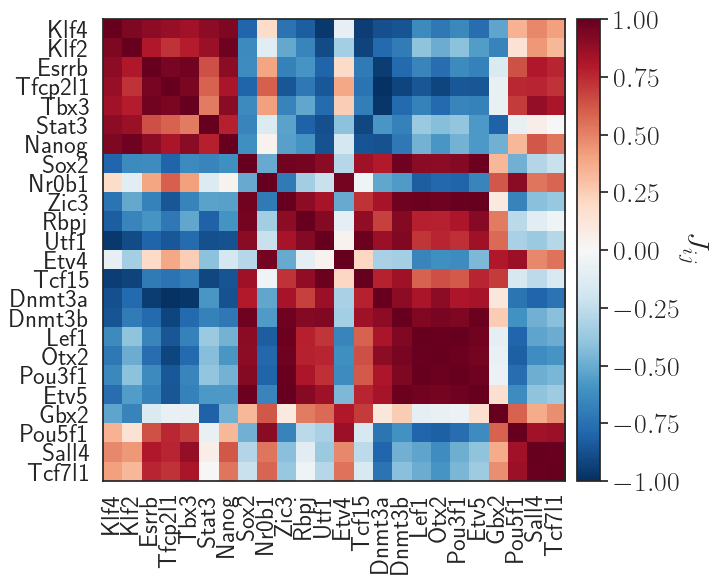

In [35]:
cm_sim_SCODE = np.corrcoef(df_sim)

# Visualize the simulated correlation matrices
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 6))
fig_func.plotmat(cm_sim_SCODE, fig, ax, genes_reference, "", fix = True)

fig.savefig(os.path.join(path_figs, 'cm_SCODE_generated.svg'), format='svg', bbox_inches='tight')
plt.show()



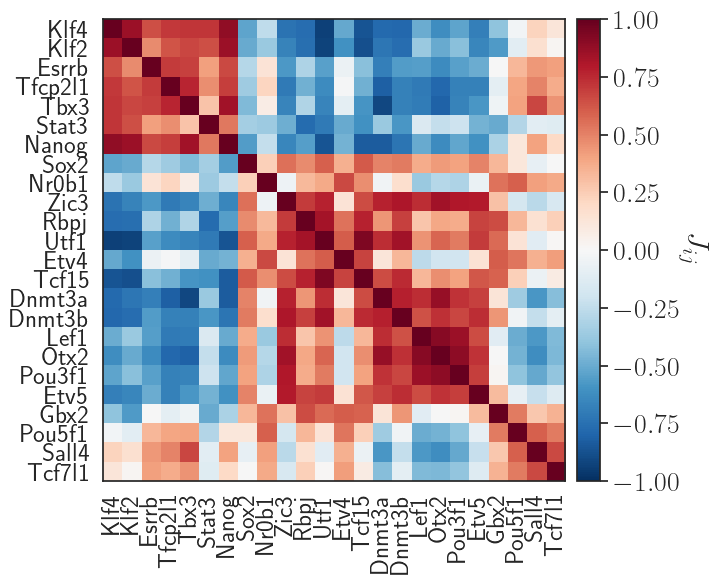

In [36]:
cm_pst_mb_psiNorm = np.corrcoef(data_LN)

# Visualize the simulated correlation matrices
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 6))
fig_func.plotmat(cm_pst_mb_psiNorm, fig, ax, genes_reference, "", fix = True)

fig.savefig(os.path.join(path_figs, 'cm_SCODE_INPUT_ge.svg'), format='svg', bbox_inches='tight')
plt.show()

### Distance between INPUT and Generated Correlation Matrices

In [37]:
N_rows = data_LN.shape[0]
N_cols = data_LN.shape[1]
Ntest=250
# Linearize
val_rnd = np.reshape(np.array(data_LN), (N_cols*N_rows))

# reshuflle for Ntest times
df_pN_mb_pst_shuffle = np.zeros((Ntest, N_rows, N_cols))

for ii in range(Ntest):
    np.random.seed(1234+ii)
    # Random reshuffle of the binnarized GE data
    np.random.shuffle(val_rnd)
    val_rnd_matx = val_rnd.reshape(N_rows,N_cols) 
    trial_long = pd.DataFrame(val_rnd_matx)

    # Save the shuffled DataFrame
    df_pN_mb_pst_shuffle[ii,:,:] = trial_long

corr_matxs_rnd = np.array([np.corrcoef(df_pN_mb_pst_shuffle[i,:,:]) for i in range(df_pN_mb_pst_shuffle.shape[0])])

print(corr_matxs_rnd.shape)

(250, 24, 24)


In [38]:
rnd_dist = np.array([funcs_ko.sum_squared_abs_diff(cm_pst_mb_psiNorm, corr_matxs_rnd[i,:,:]) for i in range(df_pN_mb_pst_shuffle.shape[0])])

dist = funcs_ko.sum_squared_abs_diff(cm_pst_mb_psiNorm, cm_sim_SCODE)

mean_rnd_dist = np.mean(rnd_dist)
std_rnd_dist = np.std(rnd_dist)

# Calcola lo z-score per dist
z_score = (dist - mean_rnd_dist) / std_rnd_dist

print("Z-Score:", z_score)


Z-Score: -428.3024609887723


In [39]:
noise_dist = np.mean([funcs_ko.sum_squared_abs_diff(cm_pst_mb_psiNorm, corr_matxs_rnd[i,:,:]) for i in range(df_pN_mb_pst_shuffle.shape[0])])
print(noise_dist)

result_SO = funcs_ko.sum_squared_abs_diff(cm_pst_mb_psiNorm, cm_sim_SCODE)/noise_dist
print(f"Scode - Orig {result_SO:.2f}")


12.69349522455519
Scode - Orig 0.51


## Clustering Generated Data

### Generated Data

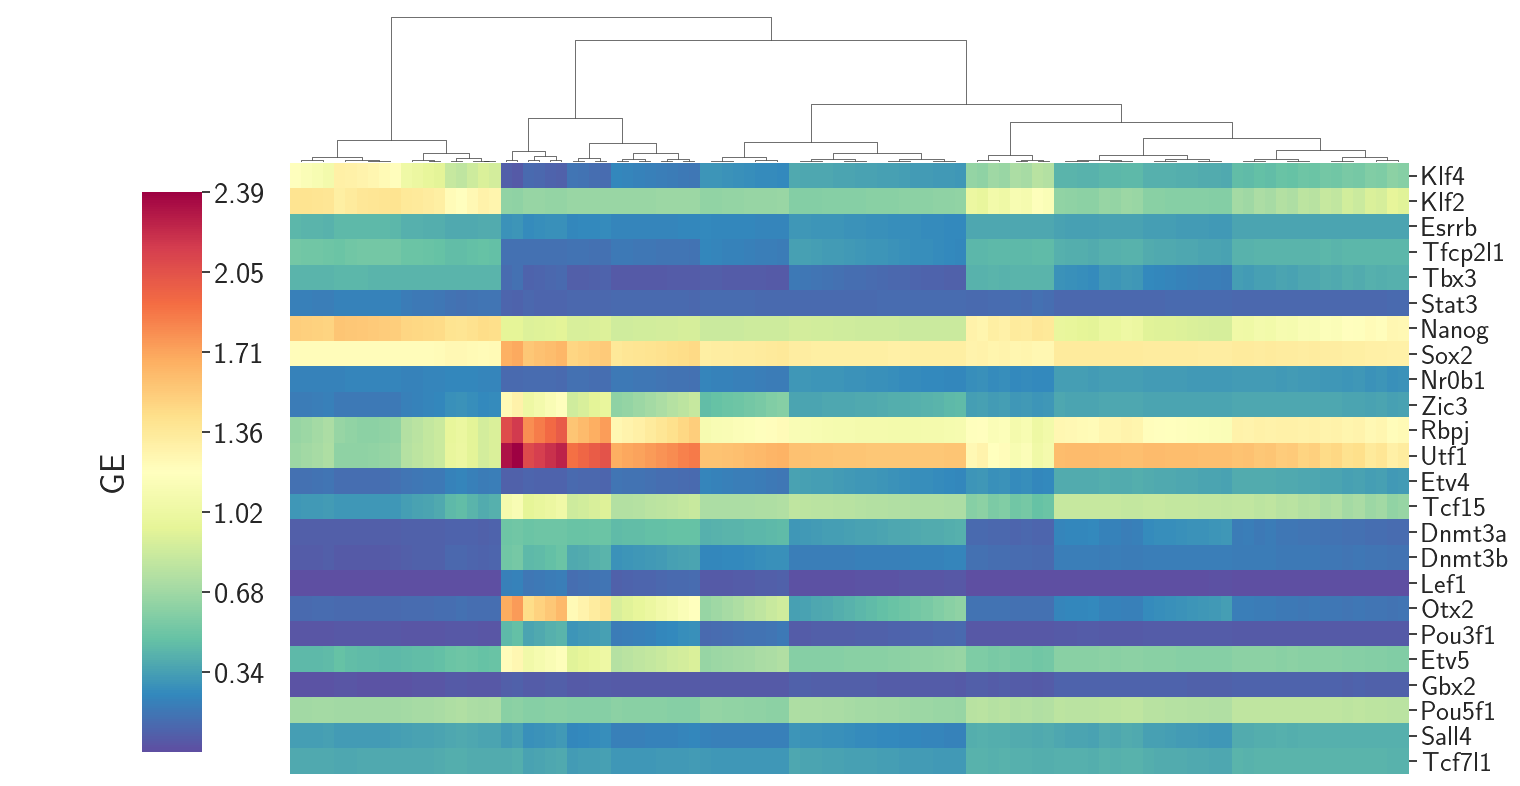

In [40]:
# Perform linkage on your numpy array
Z = linkage(df_sim.T, method='ward')

# Create a custom colorbar with more ticks
max_value = df_sim.max().max()
cbar_kws = {"ticks": np.linspace(0, max_value, num=8), "label": "GE"}

# Plot the dendrogram and heatmap with custom colorbar
g = sns.clustermap(df_sim, col_linkage=Z, cmap='Spectral_r', yticklabels=genes_reference,
                   cbar=True, cbar_kws=cbar_kws, figsize=(15, 8), row_cluster=False, xticklabels=False)

# Adjust the colorbar size to match the heatmap
g.cax.set_position([.1, .05, .04, .7])

# Set the font size of the ticks for heatmap and colorbar
for label in g.ax_heatmap.get_yticklabels():
    label.set_size(20)
g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_yticklabels(), rotation=0)

for label in g.cax.get_yticklabels():
    label.set_size(22)
    
# set the font size of the colorbar label to 18
g.cax.yaxis.label.set_size(25)
g.cax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))
g.cax.yaxis.labelpad = 8
g.cax.yaxis.set_label_position('left')
# g.cax.yaxis.set_ticks_position('left')

plt.savefig(path_figs+'/generated_wt_generated_SCODE_data_clustering.tiff', format='tiff', transparent=True, bbox_inches='tight')

plt.show()


In [41]:
# find the number of cells in each cluster in which we are interested
n_cells = Z.shape[0]+1
# chech the number of naive cells
n_cells_cluster_naive = Z[-2,3]
print(f"Number of mixed cells: {n_cells_cluster_naive}, fraction: {n_cells_cluster_naive/n_cells:.2f}")
n_cells_cluster_mixed = n_cells-n_cells_cluster_naive
print(f"Number of naive cells: {n_cells_cluster_mixed}, fraction: {n_cells_cluster_mixed/n_cells:.2f}")

Number of mixed cells: 82.0, fraction: 0.81
Number of naive cells: 19.0, fraction: 0.19


### Input Data

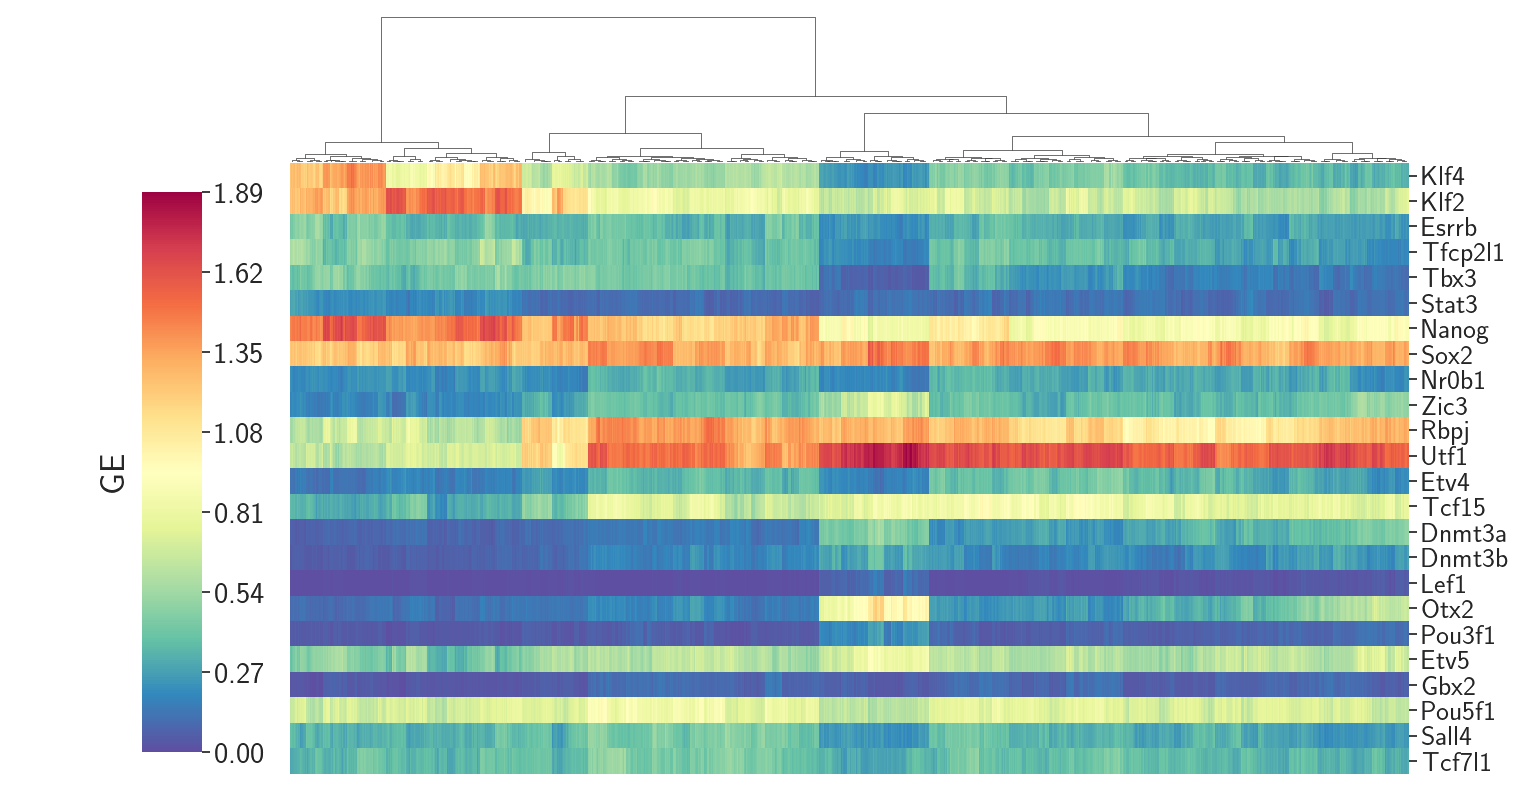

In [42]:
# Perform linkage on your numpy array
Z = linkage(data_LN.T, method='ward')

# Create a custom colorbar with more ticks
max_value = data_LN.max().max()
cbar_kws = {"ticks": np.linspace(0, max_value, num=8), "label": "GE"}

# Plot the dendrogram and heatmap with custom colorbar
g = sns.clustermap(data_LN, col_linkage=Z, cmap='Spectral_r', yticklabels=genes_reference,
                   cbar=True, cbar_kws=cbar_kws, figsize=(15, 8), row_cluster=False, xticklabels=False)

# Adjust the colorbar size to match the heatmap
g.cax.set_position([.1, .05, .04, .7])

# Set the font size of the ticks for heatmap and colorbar
for label in g.ax_heatmap.get_yticklabels():
    label.set_size(20)
g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_yticklabels(), rotation=0)

for label in g.cax.get_yticklabels():
    label.set_size(22)
    
# set the font size of the colorbar label to 18
g.cax.yaxis.label.set_size(25)
g.cax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))
g.cax.yaxis.labelpad = 8
g.cax.yaxis.set_label_position('left')
# g.cax.yaxis.set_ticks_position('left')

plt.savefig(path_figs+'/generated_wt_input_SCODE_data_clustering.tiff', format='tiff', transparent=True, bbox_inches='tight')

plt.show()


In [43]:
# find the number of cells in each cluster in which we are interested
n_cells = Z.shape[0]+1
# chech the number of naive cells
n_cells_cluster_naive = Z[-2,3]
print(f"Number of mixed cells: {n_cells_cluster_naive}, fraction: {n_cells_cluster_naive/n_cells:.2f}")
n_cells_cluster_mixed = n_cells-n_cells_cluster_naive
print(f"Number of naive cells: {n_cells_cluster_mixed}, fraction: {n_cells_cluster_mixed/n_cells:.2f}")

Number of mixed cells: 7570.0, fraction: 0.79
Number of naive cells: 1977.0, fraction: 0.21


In [44]:
# ## Input/Generated with SCODE GE visualization - no clustering
# plt.figure(figsize=(15,8))
# sns.heatmap(data_LN, cmap='Spectral_r',yticklabels=genes_reference)
# plt.show()

# plt.figure(figsize=(15,8))
# sns.heatmap(df_sim[:,:,0], cmap='Spectral_r',yticklabels=genes_reference)
# plt.show()

# KO

## Functions

In [45]:
def KO_comparison_ExpVsSim(lofFC_Exp, logFC_Sim, N_test=100):
    """compute the fraction of Experimental Data end Simulated data in Agreement"""
    comparison= np.array([np.sign(lofFC_Exp)*np.sign(logFC_Sim[ii,:]) for ii in range(N_test)])
#     print(np.sum([len(np.where(logFC_Sim[:,ii]==0)[0]) for ii in range(N_test)]))
    data_considered = np.array([len(np.where(comparison[ii,:]!=0)[0]) for ii in range(N_test)])
    
    in_agreement = np.array([len(np.where(comparison[ii,:]==1)[0])/data_considered[ii] for ii in range(N_test)])
    no_agreement = np.array([len(np.where(comparison[ii,:]==-1)[0])/data_considered[ii] for ii in range(N_test)])
    mean_in_agreement = np.mean(in_agreement)
    
    # Check
    check_sum = np.array([in_agreement[ii]+no_agreement[ii] for ii in range(N_test)])-1
    check = np.where(check_sum>0.001)[0]
    if check.size > 0:
        print("Error in comparison Exp and Sim")
    return(mean_in_agreement,    data_considered)


In [46]:
def KO_plotLogFC_ExpAndSim(lofFC_Exp, logFC_Sim, KO_genes_reference):
    plt.figure(figsize=(18,5))
    plt.plot(lofFC_Exp, 
             "o",ms = 10, label="Exp")
    plt.plot(logFC_Sim[:,0],  
             "o", ms = 10,
             color="darkred", label= "Sim")
    plt.xticks(np.arange(0,23),KO_genes_reference)
    plt.axhline(0)
    plt.legend()

## Rbpj

In [47]:
# get the initial gene expression and the KO interaction matrix to simulate the KO data
KO_gene = "Rbpj"
KO_gene_idk = np.where(genes_reference ==KO_gene)[0][0] # index of the gene to be knocked out
KO_genes_reference_R = np.delete(genes_reference, KO_gene_idk, axis=0) # remove the KO gene from the list of genes

KO_lN_rec_matx = np.delete(A_tot, KO_gene_idk, axis=0) # remove the row of the KO gene
KO_lN_rec_matx = np.delete(KO_lN_rec_matx, KO_gene_idk, axis=1) # remove the column

# input_ge_SCODE
KO_input_ge_SCODE = df_lN_mb_pst.drop(KO_gene)
KO_input_ge_SCODE.to_csv(path_data+"OUT_SCODE_LN/KO_LN/RBPJ/initial_GE_LogNorm_MB_KO.txt", sep='\t', index=False, header=False)

# np.savetxt(path_data+ "OUT_SCODE_LN/KO_LN/RBPJ/A_KO_LogNorm_MB.txt",KO_lN_rec_matx)


In [48]:
compute = False

out_sim = "/Users/cleliacorridori/Dropbox_2021\ Dropbox/Jorah\ Mormont/GRN_Inference/DATA/OUT_SCODE_LN/KO_LN/RBPJ/OUT/out_simSCODE_LogNorm_MB_"+str(0)+".txt"
if compute == True:
    # call R script Reconstruct_dynamics.R
    ! Rscript /Users/cleliacorridori/Dropbox_2021\ Dropbox/Jorah\ Mormont/GRN_Inference/GRN_Inference_CODE/Reconstruct_dynamics.R /Users/cleliacorridori/Dropbox_2021\ Dropbox/Jorah\ Mormont/GRN_Inference/DATA/OUT_SCODE_LN/KO_LN/RBPJ/initial_GE_LogNorm_MB_KO.txt /Users/cleliacorridori/Dropbox_2021\ Dropbox/Jorah\ Mormont/GRN_Inference/DATA/OUT_SCODE_LN/KO_LN/RBPJ/A_KO_LogNorm_MB.txt {out_sim} {23}

# load simulated data
KO_df_sim = pd.read_table(path_data+"OUT_SCODE_LN/KO_LN/RBPJ/OUT/out_simSCODE_LogNorm_MB_"+str(0)+".txt", delimiter="\t", dtype={"Value": float}).set_index(KO_genes_reference_R)

# check if KO_df_sim has negative values
print(np.sum(np.sum(KO_df_sim<0, axis=0), axis=0)/KO_df_sim.size)
# KO_df_sim[KO_df_sim<0]=0
    

0.155832974601808


In [49]:
# compute the average and std of the simulated  KO data
KO_R_df_sim_avg  = np.mean(KO_df_sim, axis=1)
KO_R_wt_avg = np.mean(KO_input_ge_SCODE, axis=1)
print("KO_R_wt_avg", KO_R_wt_avg.shape, "KO_R_df_sim_avg", KO_R_df_sim_avg.shape)

KO_R_diff = funcs_ko.KO_diff_sim_no_std(KO_R_df_sim_avg ,KO_R_wt_avg)
logFC_Leeb_R = np.delete(np.array(df_KO_N24_Leeb_uncl[KO_gene]), KO_gene_idk) # logFC Leeb


KO_R_wt_avg (23,) KO_R_df_sim_avg (23,)


## Etv5

In [50]:
KO_gene = "Etv5"
KO_gene_idk = np.where(genes_reference ==KO_gene)[0][0]
KO_genes_reference_E = np.delete(genes_reference, KO_gene_idk, axis=0)

# KO_lN_rec_matx = np.delete(lN_rec_matx, KO_gene_idk, axis=0)
KO_lN_rec_matx = np.delete(A_tot, KO_gene_idk, axis=0)
KO_lN_rec_matx = np.delete(KO_lN_rec_matx, KO_gene_idk, axis=1)

KO_input_ge_SCODE = df_lN_mb_pst.drop(KO_gene)
KO_input_ge_SCODE.to_csv(path_data+"OUT_SCODE_LN/KO_LN/ETV5/initial_GE_LogNorm_MB_KO.txt", sep='\t', index=False, header=False)

# np.savetxt(path_data+ "OUT_SCODE_LN/KO_LN/ETV5/A_KO_LogNorm_MB.txt",KO_lN_rec_matx)

In [51]:
compute = False
out_sim = "/Users/cleliacorridori/Dropbox_2021\ Dropbox/Jorah\ Mormont/GRN_Inference/DATA/OUT_SCODE_LN/KO_LN/ETV5/OUT/out_simSCODE_LogNorm_MB_"+str(0)+".txt"

if compute == True:
    # call R script Reconstruct_dynamics.R
    ! Rscript /Users/cleliacorridori/Dropbox_2021\ Dropbox/Jorah\ Mormont/GRN_Inference/GRN_Inference_CODE/Reconstruct_dynamics.R /Users/cleliacorridori/Dropbox_2021\ Dropbox/Jorah\ Mormont/GRN_Inference/DATA/OUT_SCODE_LN/KO_LN/ETV5/initial_GE_LogNorm_MB_KO.txt /Users/cleliacorridori/Dropbox_2021\ Dropbox/Jorah\ Mormont/GRN_Inference/DATA/OUT_SCODE_LN/KO_LN/ETV5/A_KO_LogNorm_MB.txt {out_sim} {23}

# load simulated data
KO_df_sim = pd.read_table(path_data+"OUT_SCODE_LN/KO_LN/ETV5/OUT/out_simSCODE_LogNorm_MB_"+str(0)+".txt", delimiter="\t", dtype={"Value": float}).set_index(KO_genes_reference_E)

# check if KO_df_sim has negative values
print(np.sum(np.sum(KO_df_sim<0, axis=0), axis=0)/KO_df_sim.size)

0.1902712010331468


In [52]:
# compute the average and std of the simulated  KO data
KO_E_df_sim_avg  = np.mean(KO_df_sim, axis=1)
KO_E_wt_avg = np.mean(KO_input_ge_SCODE, axis=1)
print("KO_E_wt_avg", KO_E_wt_avg.shape, "KO_E_df_sim_avg", KO_E_df_sim_avg.shape)

KO_E_diff = funcs_ko.KO_diff_sim_no_std(KO_E_df_sim_avg ,KO_E_wt_avg)
logFC_Leeb_E = np.delete(np.array(df_KO_N24_Leeb_uncl[KO_gene]), KO_gene_idk) # logFC Leeb


KO_E_wt_avg (23,) KO_E_df_sim_avg (23,)


## Tcf7l1

In [53]:
KO_gene = "Tcf7l1"
KO_gene_idk = np.where(genes_reference ==KO_gene)[0][0]
KO_genes_reference_T = np.delete(genes_reference, KO_gene_idk, axis=0)

# KO_lN_rec_matx = np.delete(lN_rec_matx, KO_gene_idk, axis=0)
KO_lN_rec_matx = np.delete(A_tot, KO_gene_idk, axis=0)
KO_lN_rec_matx = np.delete(KO_lN_rec_matx, KO_gene_idk, axis=1)

KO_input_ge_SCODE = df_lN_mb_pst.drop(KO_gene)
KO_input_ge_SCODE.to_csv(path_data+"OUT_SCODE_LN/KO_LN/TCF7L1/initial_GE_LogNorm_MB_KO.txt", sep='\t', index=False, header=False)

# np.savetxt(path_data+ "OUT_SCODE_LN/KO_LN/TCF7L1/A_KO_LogNorm_MB.txt",KO_lN_rec_matx)

In [54]:
compute = False
out_sim = "/Users/cleliacorridori/Dropbox_2021\ Dropbox/Jorah\ Mormont/GRN_Inference/DATA/OUT_SCODE_LN/KO_LN/TCF7L1/OUT/out_simSCODE_LogNorm_MB_"+str(0)+".txt"

if compute==True:
    # call R script Reconstruct_dynamics.R
    ! Rscript /Users/cleliacorridori/Dropbox_2021\ Dropbox/Jorah\ Mormont/GRN_Inference/GRN_Inference_CODE/Reconstruct_dynamics.R /Users/cleliacorridori/Dropbox_2021\ Dropbox/Jorah\ Mormont/GRN_Inference/DATA/OUT_SCODE_LN/KO_LN/TCF7L1/initial_GE_LogNorm_MB_KO.txt /Users/cleliacorridori/Dropbox_2021\ Dropbox/Jorah\ Mormont/GRN_Inference/DATA/OUT_SCODE_LN/KO_LN/TCF7L1/A_KO_LogNorm_MB.txt {out_sim} {23}

# load simulated data
KO_df_sim = pd.read_table(path_data+"OUT_SCODE_LN/KO_LN/TCF7L1/OUT/out_simSCODE_LogNorm_MB_"+str(0)+".txt", delimiter="\t", dtype={"Value": float}).set_index(KO_genes_reference_T)

# check if KO_df_sim has negative values
print(np.sum(np.sum(KO_df_sim<0, axis=0), axis=0)/KO_df_sim.size)
# KO_df_sim[KO_df_sim<0]=0
    

0.0012914334911752045


In [55]:
# compute the average and std of the simulated  KO data
KO_T_df_sim_avg  = np.mean(KO_df_sim, axis=1)
KO_T_wt_avg = np.mean(KO_input_ge_SCODE, axis=1)
print("KO_T_wt_avg", KO_T_wt_avg.shape, "KO_T_df_sim_avg", KO_T_df_sim_avg.shape)

KO_T_diff = funcs_ko.KO_diff_sim_no_std(KO_T_df_sim_avg ,KO_T_wt_avg)
logFC_Leeb_T = np.delete(np.array(df_KO_N24_Leeb_uncl[KO_gene]), KO_gene_idk) # logFC Leeb


KO_T_wt_avg (23,) KO_T_df_sim_avg (23,)


# Three KO

In [56]:
KO_gene = ["Rbpj", "Etv5", "Tcf7l1"]
KO_gene_idk = [np.where(genes_reference == KO_gene[i])[0][0]  for i in range(len(KO_gene))]
KO_genes_reference = np.delete(genes_reference, KO_gene_idk, axis=0)

KO_lN_rec_matx = np.delete(A_tot, KO_gene_idk, axis=0)
KO_lN_rec_matx = np.delete(KO_lN_rec_matx, KO_gene_idk, axis=1)

KO_input_ge_SCODE = df_lN_mb_pst.drop(KO_gene)


In [57]:
compute = False
out_sim = "/Users/cleliacorridori/Dropbox_2021\ Dropbox/Jorah\ Mormont/GRN_Inference/DATA/OUT_SCODE_LN/KO_LN/MULT/OUT/out_simSCODE_LogNorm_MB_"+str(0)+".txt"

if compute==True:
    # call R script Reconstruct_dynamics.R
    ! Rscript /Users/cleliacorridori/Dropbox_2021\ Dropbox/Jorah\ Mormont/GRN_Inference/GRN_Inference_CODE/Reconstruct_dynamics.R /Users/cleliacorridori/Dropbox_2021\ Dropbox/Jorah\ Mormont/GRN_Inference/DATA/OUT_SCODE_LN/KO_LN/MULT/initial_GE_LogNorm_MB_KO.txt /Users/cleliacorridori/Dropbox_2021\ Dropbox/Jorah\ Mormont/GRN_Inference/DATA/OUT_SCODE_LN/KO_LN/MULT/A_KO_LogNorm_MB.txt {out_sim} {21}

# load simulated data
KO_df_sim = pd.read_table(path_data+"OUT_SCODE_LN/KO_LN/MULT/OUT/out_simSCODE_LogNorm_MB_"+str(0)+".txt", delimiter="\t", dtype={"Value": float}).set_index(KO_genes_reference)

# check if KO_df_sim has negative values
print(np.sum(np.sum(KO_df_sim<0, axis=0), axis=0)/KO_df_sim.size)
# KO_df_sim[KO_df_sim<0]=0
    


0.01603017444601603


#### Clustering of tripleKO generated Data with scode 

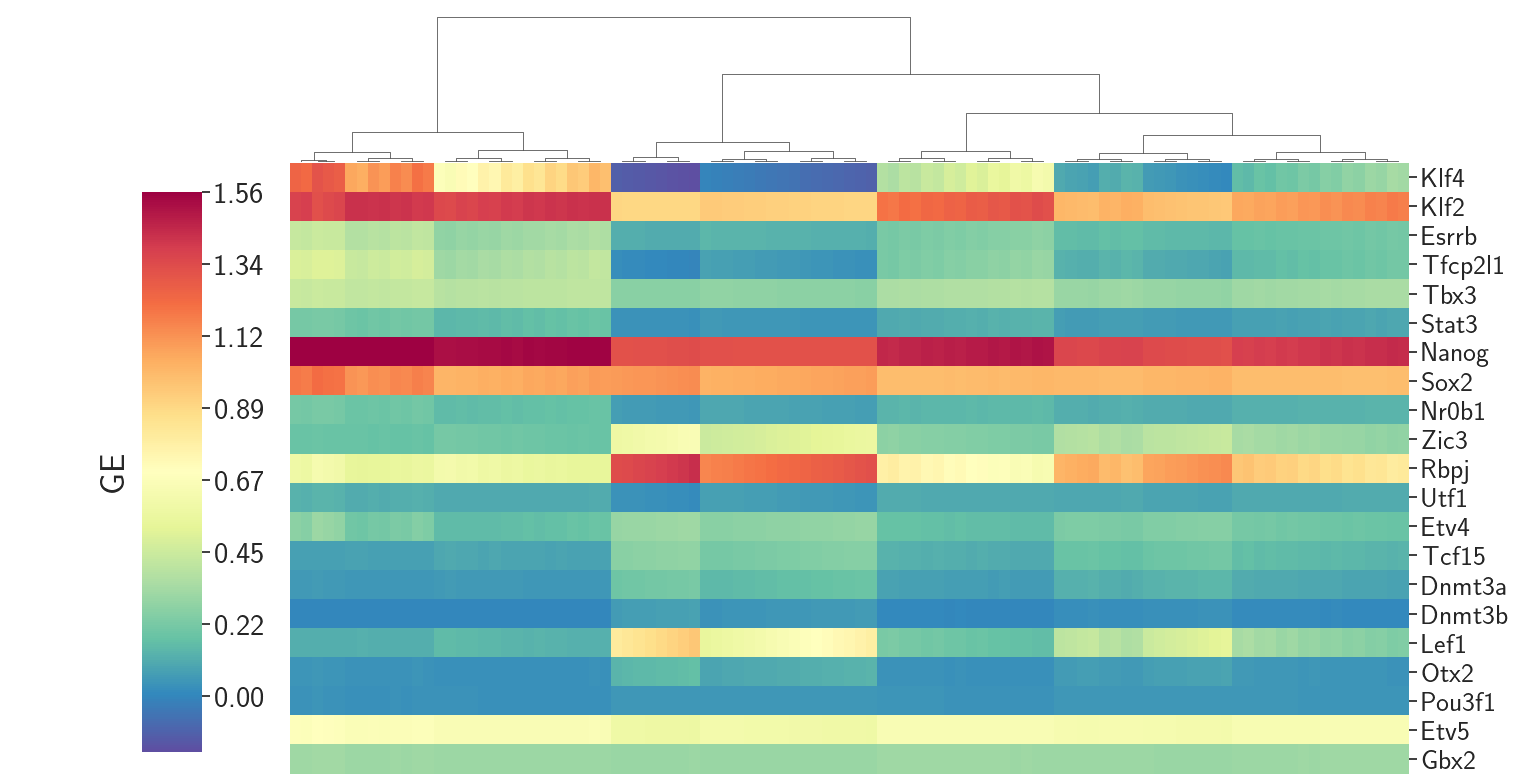

In [58]:
# Perform linkage on your numpy array
Z = linkage(KO_df_sim.T, method='ward')

# Create a custom colorbar with more ticks
max_value = KO_df_sim.max().max()
cbar_kws = {"ticks": np.linspace(0, max_value, num=8), "label": "GE"}

# Plot the dendrogram and heatmap with custom colorbar
g = sns.clustermap(KO_df_sim, col_linkage=Z, cmap='Spectral_r', yticklabels=genes_reference,
                   cbar=True, cbar_kws=cbar_kws, figsize=(15, 8), row_cluster=False, xticklabels=False)

# Adjust the colorbar size to match the heatmap
g.cax.set_position([.1, .05, .04, .7])

# Set the font size of the ticks for heatmap and colorbar
for label in g.ax_heatmap.get_yticklabels():
    label.set_size(20)
g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_yticklabels(), rotation=0)

for label in g.cax.get_yticklabels():
    label.set_size(22)
    
# set the font size of the colorbar label to 18
g.cax.yaxis.label.set_size(25)
g.cax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))
g.cax.yaxis.labelpad = 8
g.cax.yaxis.set_label_position('left')
# g.cax.yaxis.set_ticks_position('left')

plt.savefig(path_figs+'/generated_tripleKO_generated_SCODE_data_clustering.tiff', format='tiff', transparent=True, bbox_inches='tight')

plt.show()


In [59]:
# find the number of cells in each cluster
n_cells = Z.shape[0]
print(n_cells)
n_cells_cluster_naive = Z[-2,3]
print("Formative cells", n_cells_cluster_naive/n_cells)
n_cells_cluster_mixed = n_cells-n_cells_cluster_naive
print("naive cells", n_cells_cluster_mixed/n_cells)

100
Formative cells 0.72
naive cells 0.28


In [60]:
# compute the average and std of the simulated  KO data
KO_Th_df_sim_avg  = np.mean(KO_df_sim, axis=1)
KO_Th_wt_avg = np.mean(KO_input_ge_SCODE, axis=1)
print("KO_T_wt_avg", KO_Th_wt_avg.shape, "KO_T_df_sim_avg", KO_Th_df_sim_avg.shape, len(KO_genes_reference))

KO_Th_diff = funcs_ko.KO_diff_sim_no_std(KO_Th_df_sim_avg ,KO_Th_wt_avg)

KO_T_wt_avg (21,) KO_T_df_sim_avg (21,) 21


In [61]:
# experimental data log2FC from Kalkan et al.
df_tKO_Kalkan_sel =df_tKO_Kalkan.drop(["Etv5", "Rbpj", "Tcf7l1"])
# check that df_tKO_Kalkan_sel has the same genes as KO_genes_reference
print(np.array_equal(df_tKO_Kalkan_sel.index, KO_genes_reference))

KO_Th_diff = funcs_ko.KO_diff_sim_no_std(KO_Th_df_sim_avg ,KO_Th_wt_avg)
df_tKO_Kalkan_sel = np.squeeze(np.array(df_tKO_Kalkan_sel.iloc[:,0]))


True


In [62]:
# Normalized differences
diff_sim   = np.array([KO_R_diff, KO_E_diff, KO_T_diff])
log2FC_exp = np.array([logFC_Leeb_R, logFC_Leeb_E, logFC_Leeb_T])
genes_KOs  = np.array([KO_genes_reference_R, KO_genes_reference_E, KO_genes_reference_T])
KO_goodness_sel = np.zeros(4)

diff_max = max(np.abs(diff_sim).max(), np.abs(KO_Th_diff).max())
diff_sim_norm = diff_sim/diff_max
diff_sim_T_norm = KO_Th_diff/diff_max

log2FC_exp_norm = log2FC_exp/np.abs(log2FC_exp).max()
df_tKO_Kalkan_norm = df_tKO_Kalkan_sel/np.abs(df_tKO_Kalkan_sel).max()

diff_thr = 0.05

# Rbpj
print(funcs_ko.fraction_agreement(diff_sim_norm[0,:], log2FC_exp_norm[0,:], genes_KOs[0,:], diff_thr))
KO_goodness_sel[0] = funcs_ko.fraction_agreement(diff_sim_norm[0,:], log2FC_exp_norm[0,:], genes_KOs[0,:], diff_thr)[3]
# Etv5
print(funcs_ko.fraction_agreement(diff_sim_norm[1,:], log2FC_exp_norm[1,:], genes_KOs[1,:], diff_thr))
KO_goodness_sel[1] = funcs_ko.fraction_agreement(diff_sim_norm[1,:], log2FC_exp_norm[1,:], genes_KOs[1,:], diff_thr)[3]
# Tcf7l1
print(funcs_ko.fraction_agreement(diff_sim_norm[2,:], log2FC_exp_norm[2,:], genes_KOs[2,:], diff_thr))
KO_goodness_sel[2] = funcs_ko.fraction_agreement(diff_sim_norm[2,:], log2FC_exp_norm[2,:], genes_KOs[2,:], diff_thr)[3]
# Triple
print(funcs_ko.fraction_agreement(diff_sim_T_norm, np.array(df_tKO_Kalkan_norm).squeeze(), np.array(KO_genes_reference), diff_thr))
KO_goodness_sel[3] = funcs_ko.fraction_agreement(diff_sim_T_norm, np.array(df_tKO_Kalkan_norm).squeeze(), np.array(KO_genes_reference), diff_thr)[3]


(0.0, 0.2608695652173913, 0.043478260869565216, 0.30434782608695654)
(0.21739130434782608, 0.0, 0.0, 0.21739130434782608)
(0.0, 0.21739130434782608, 0.08695652173913043, 0.30434782608695654)
(0.14285714285714285, 0.09523809523809523, 0.23809523809523808, 0.47619047619047616)


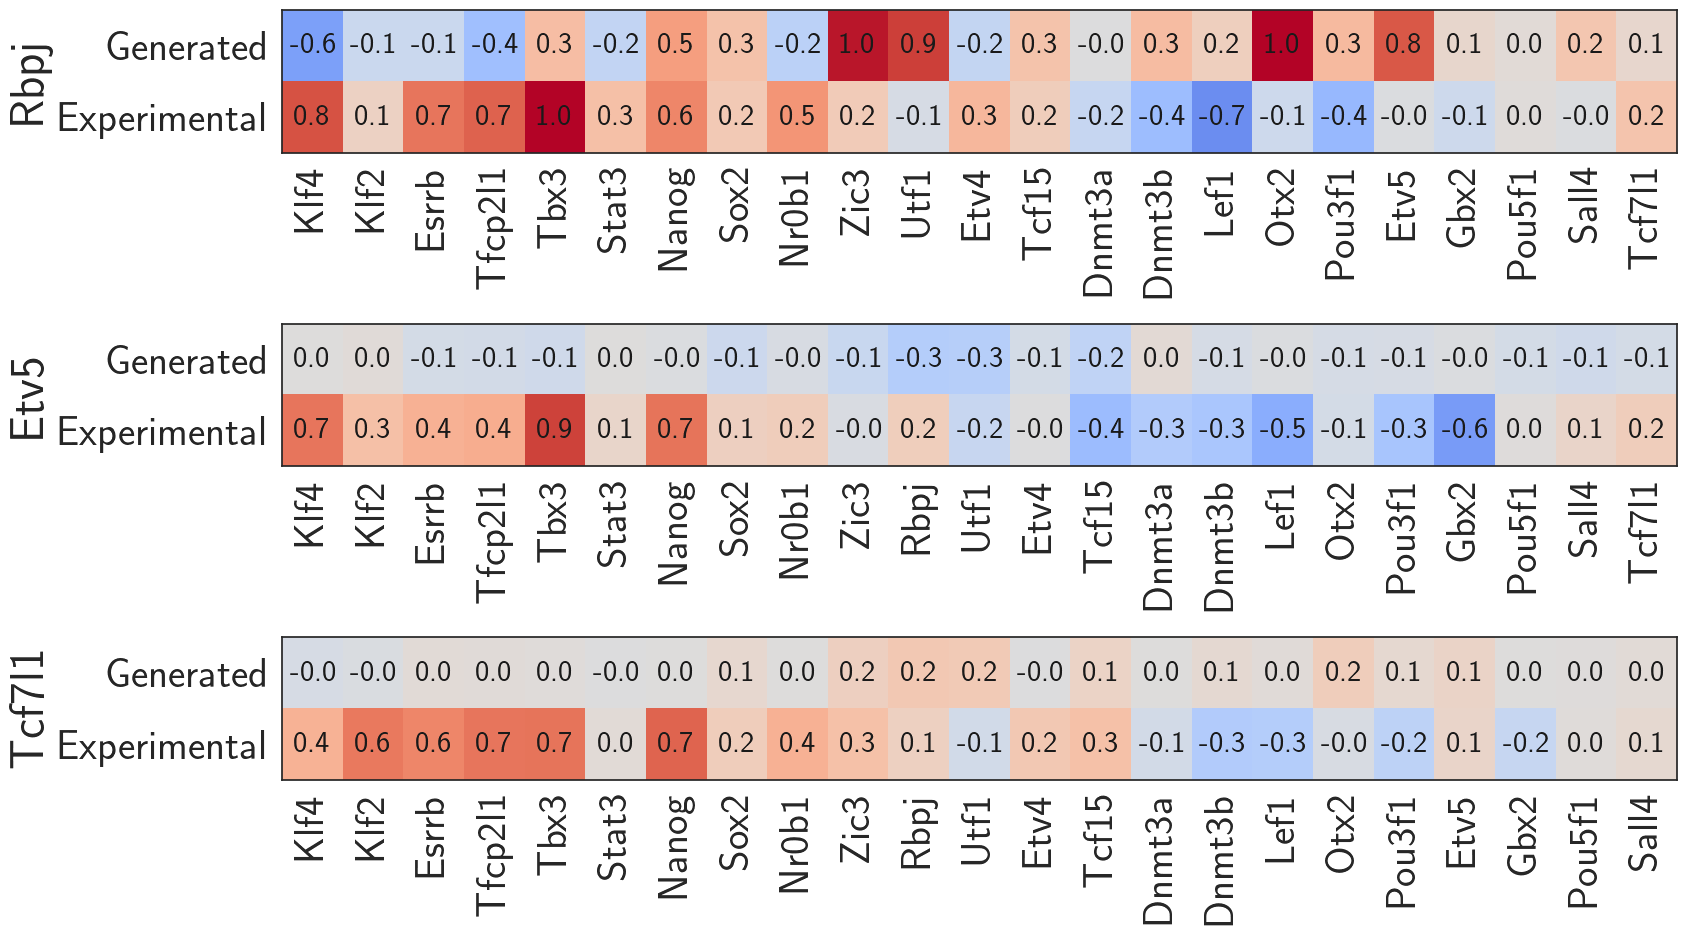

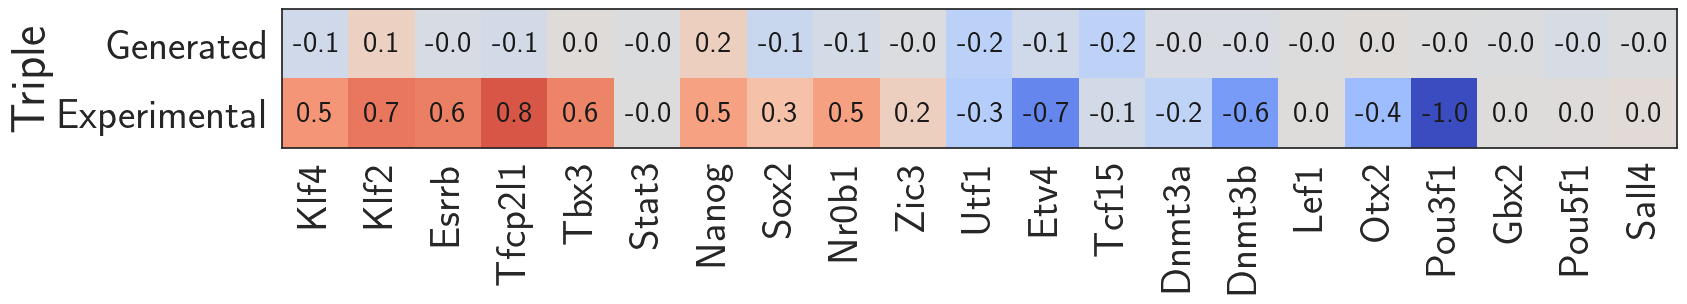

In [63]:
fig, ax = plt.subplots(3, 1, figsize=(18,10), gridspec_kw={'height_ratios': [1,1,1]})
funcs_ko.KO_heat_comparison_T(diff_sim_norm[0,:], log2FC_exp_norm[0,:], "Rbpj", genes_KOs[0,:], fig, ax[0], Norm=False)
funcs_ko.KO_heat_comparison_T(diff_sim_norm[1,:], log2FC_exp_norm[1,:], "Etv5", genes_KOs[1,:], fig, ax[1], Norm=False)
funcs_ko.KO_heat_comparison_T(diff_sim_norm[2,:], log2FC_exp_norm[2,:], "Tcf7l1", genes_KOs[2,:], fig, ax[2], Norm=False)
plt.subplots_adjust(hspace=1.2)
# save the figure as svg
fig.savefig(os.path.join(path_figs, 'single_KO_heatmap_SCODE.svg'), format='svg', bbox_inches='tight',  transparent=True,)
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(18,1.8), gridspec_kw={'height_ratios': [1]})
funcs_ko.KO_heat_comparison_T(diff_sim_T_norm, np.array(df_tKO_Kalkan_norm).squeeze(), "Triple", np.array(KO_genes_reference),fig, ax,  Norm=False)
fig.savefig(os.path.join(path_figs, 'triple_KO_heatmap_SCODE.svg'), format='svg', bbox_inches='tight', transparent=True)

plt.show()


In [64]:
np.random.seed(0)

PST_MB_val = pd.read_csv(path_data+"PST_MB_values_not_scaled.txt", header=None, sep="\t")

In [65]:
df_lN_mb_pst_reduced = np.delete(df_lN_mb_pst, KO_gene_idk, axis=0)

pca_reduced = PCA(n_components=2)
pca_reduced.fit(df_lN_mb_pst_reduced.T)

principalComponents_reduced_full = pca_reduced.transform(df_lN_mb_pst_reduced.T)
KO_T_transformed = pca_reduced.transform(KO_df_sim.T)

principalComponents_reduced_full[:,0] = -principalComponents_reduced_full[:,0]
KO_T_transformed[:,0] = -KO_T_transformed[:,0]

principalDf_full_reduced = pd.DataFrame(data=principalComponents_reduced_full, columns=['PC1', 'PC2'])
KO_T_pca_df = pd.DataFrame(data=KO_T_transformed, columns=['PC1', 'PC2'])


/Users/cleliacorridori/anaconda3/envs/ignite_env/lib/python3.8/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


In [66]:
pca_input = PCA(n_components=2)
pca_input.fit(df_lN_mb_pst.T)

input_transformed = pca_input.transform(df_lN_mb_pst.T)
new_transformed = pca_input.transform(df_sim.T)
# change the sign of PC1
input_transformed[:,0] = -input_transformed[:,0]
new_transformed[:,0] = -new_transformed[:,0]

principalDf_input = pd.DataFrame(data=input_transformed, columns=['PC1', 'PC2'])
principalDf_new = pd.DataFrame(data=new_transformed, columns=['PC1', 'PC2'])



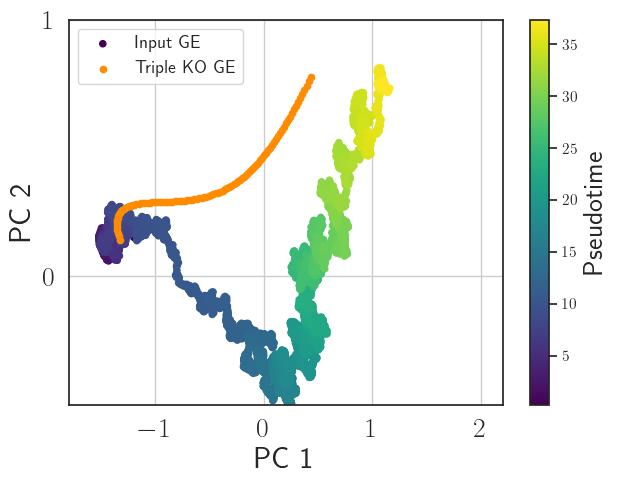

In [67]:
import matplotlib.colors as colors

plt.figure(figsize=(7, 5))
plt.scatter(principalDf_input['PC1'], principalDf_input['PC2'], label='Input GE', c=PST_MB_val.iloc[:,1], cmap='viridis', s=20, marker='o', alpha=1.0)
cbar = plt.colorbar()
cbar.set_label('Pseudotime', size=20) 
plt.scatter(KO_T_pca_df['PC1'], KO_T_pca_df['PC2'], label='Triple KO GE', c='darkorange', s=20, marker='o', alpha=1.0)

plt.legend(prop={'size': 13, 'family': 'Avenir'}, loc='upper left')
plt.xlabel('PC 1', fontdict=font)
plt.ylabel('PC 2', fontdict=font)
plt.xticks(fontsize=20, fontname='Avenir')
plt.yticks(fontsize=20, fontname='Avenir')
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(integer=True))
plt.gca().yaxis.set_major_locator(plt.MaxNLocator(integer=True))
plt.grid(True)
plt.xlim([-1.8,2.2])
plt.ylim([-.5,1])

plt.savefig(path_figs+'/PCA_SCODE_input_KO_GE.svg', format='svg', transparent=True, bbox_inches='tight')
plt.show()


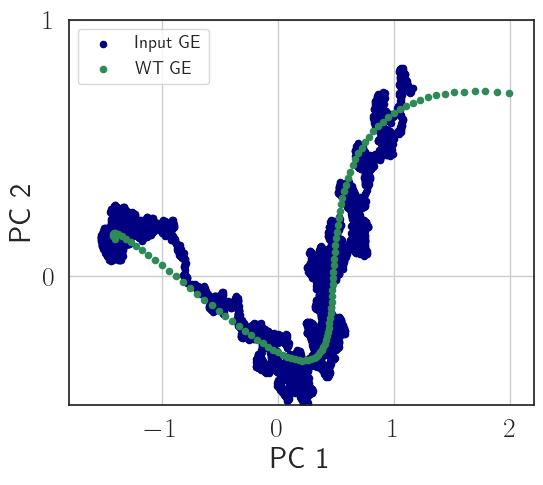

In [68]:
import matplotlib.colors as colors

plt.figure(figsize=(6, 5))
plt.scatter(principalDf_input['PC1'], principalDf_input['PC2'], label='Input GE', c='navy', s=20, marker='o', alpha=1.0)
plt.scatter(principalDf_new['PC1'], principalDf_new['PC2'], label='WT GE', c='seagreen', s=20, marker='o', alpha=1.0)


plt.legend(prop={'size': 13, 'family': 'Avenir'}, loc='upper left')
plt.xlabel('PC 1', fontdict=font)
plt.ylabel('PC 2', fontdict=font)
plt.xticks(fontsize=20, fontname='Avenir')
plt.yticks(fontsize=20, fontname='Avenir')
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(integer=True))
plt.gca().yaxis.set_major_locator(plt.MaxNLocator(integer=True))
plt.grid(True)
plt.xlim([-1.8,2.2])
plt.ylim([-.5,1])

plt.savefig(path_figs+'/PCA_SCODE_input_WT_GE.svg', format='svg', transparent=True, bbox_inches='tight')
plt.show()
